<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *DATA SCIENCE / SECTION 2 / SPRINT 2 / NOTE 2*

# 📝 Assignment
---

# 랜덤포레스트(Random Forests)

### 1) 캐글 대회를 이어서 진행합니다. EDA, 데이터 전처리 부분을 업데이트 하세요.
- EDA는 항상 완벽할 수 없지요 한 주간 계속 같은 데이터로 과제를 진행하므로 부족한 부분을 추가하거나 논하세요.
- (지금은 feature engineering에 너무 시간을 들이지 마세요!)
- Ordinal Encoding을 적용해 보세요.
- **(객관식) 다음 특성들 중에 순서를 고려한 Ordinal Encoding이 필요해 보이는 특성을 선택하고 과제 제출폼에 제출하세요.**
    1. opinion_h1n1_vacc_effective
    2. state
    3. marital
    4. employment_occupation


In [1]:
### 이곳에서 과제를 진행해 주세요 ###

import pandas as pd

url_train = "https://raw.githubusercontent.com/tkryu91/drive/main/Code%20States/Section%202/n221/train.csv"
url_train_labels="https://raw.githubusercontent.com/tkryu91/drive/main/Code%20States/Section%202/n221/train_labels.csv"
url_test = "https://raw.githubusercontent.com/tkryu91/drive/main/Code%20States/Section%202/n221/test.csv"
url_submission = "https://raw.githubusercontent.com/tkryu91/drive/main/Code%20States/Section%202/n221/submission.csv"

target = 'vacc_h1n1_f'


train_raw = pd.merge(pd.read_csv(url_train),
                 pd.read_csv(url_train_labels)[target],
                left_index=True, right_index=True)



## feature 설명 

**opinion_h1n1_vacc_effective = 신종 플루 백신의 효과에 대한 개인의 의견.**  
$\qquad$ (전혀 효과 없다 / 별로 효과 없다 / 모른다 / 어느 정도 효과 있다 / 효과 좋다)  

**state : 거주 도시**

**marital : 결혼 여부**

**employment_occupation : 직업**

<span style = 'color : red'> **우선 state와 marital은 categorical 한 것이 분명해 보이고, opinion의 경우, 백신 효과에 대한 긍정 / 부정의 정도에 따라 백신 접종률이 다를 것이므로, ordinal encoding을 하면 좋을 것으로 판단된다.**
    
**<span style = 'color : red'> 하지만 아래 표에서 보듯, 직업의 종류에 따라서도 백신 접종률이 다른데 occupation 항목에 대해선 ordinal encoding이 필요하지 않는지 모르겠다.**
    


<AxesSubplot:xlabel='employment_occupation', ylabel='vacc_h1n1_f'>

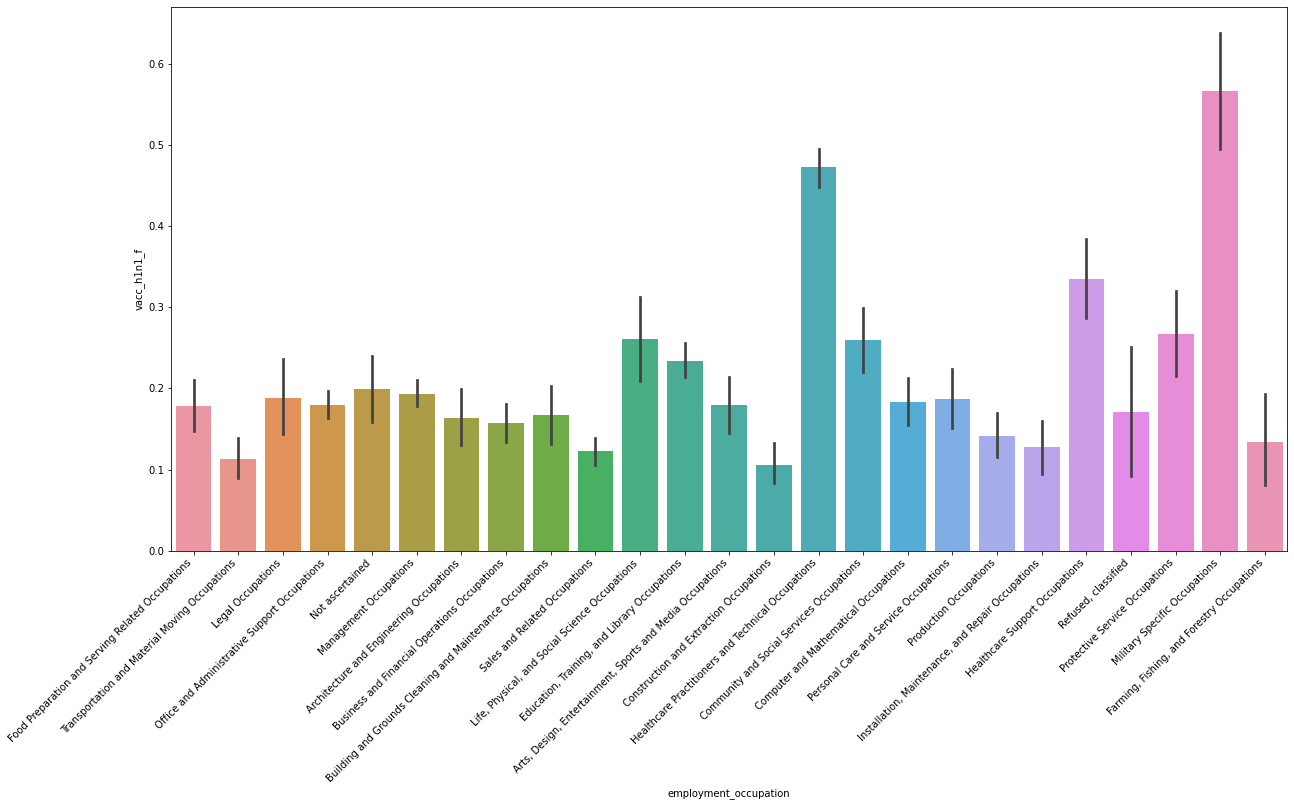

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

fit, ax = plt.subplots(figsize = (20,10))

# h = plt.bar(xrange(len(country_list)), heights, label=country_list)


plt.xticks(rotation = 45, ha = 'right')
plt.rcParams['font.size'] = 20

sns.barplot(ax = ax, data = train_raw, x='employment_occupation', y=target, )

<AxesSubplot:xlabel='opinion_h1n1_vacc_effective', ylabel='vacc_h1n1_f'>

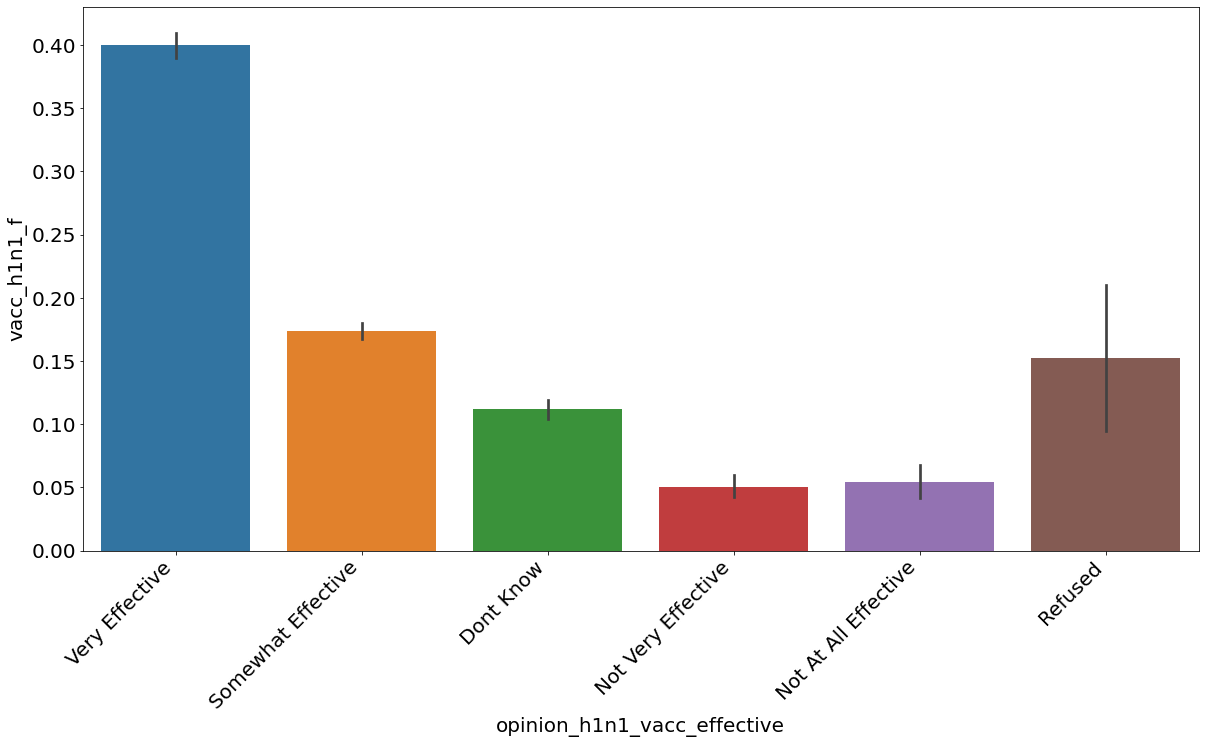

In [3]:
fit, ax = plt.subplots(figsize = (20,10))
plt.xticks(rotation = 45, ha = 'right')
plt.rcParams['font.size'] = 20

order = ['Very Effective', 'Somewhat Effective', 'Dont Know', 'Not Very Effective', 'Not At All Effective', 'Refused']

sns.barplot(ax = ax, data = train_raw, x='opinion_h1n1_vacc_effective', y=target,
           order = order)

In [4]:
#근데 Opinion 항목에서 Not At All Effective의 접종률이 Not Very Effective보다 높은게 이상했다
#혹시 바 플롯을 잘못 그린건가 확인해보자


<AxesSubplot:xlabel='opinion_h1n1_vacc_effective', ylabel='count'>

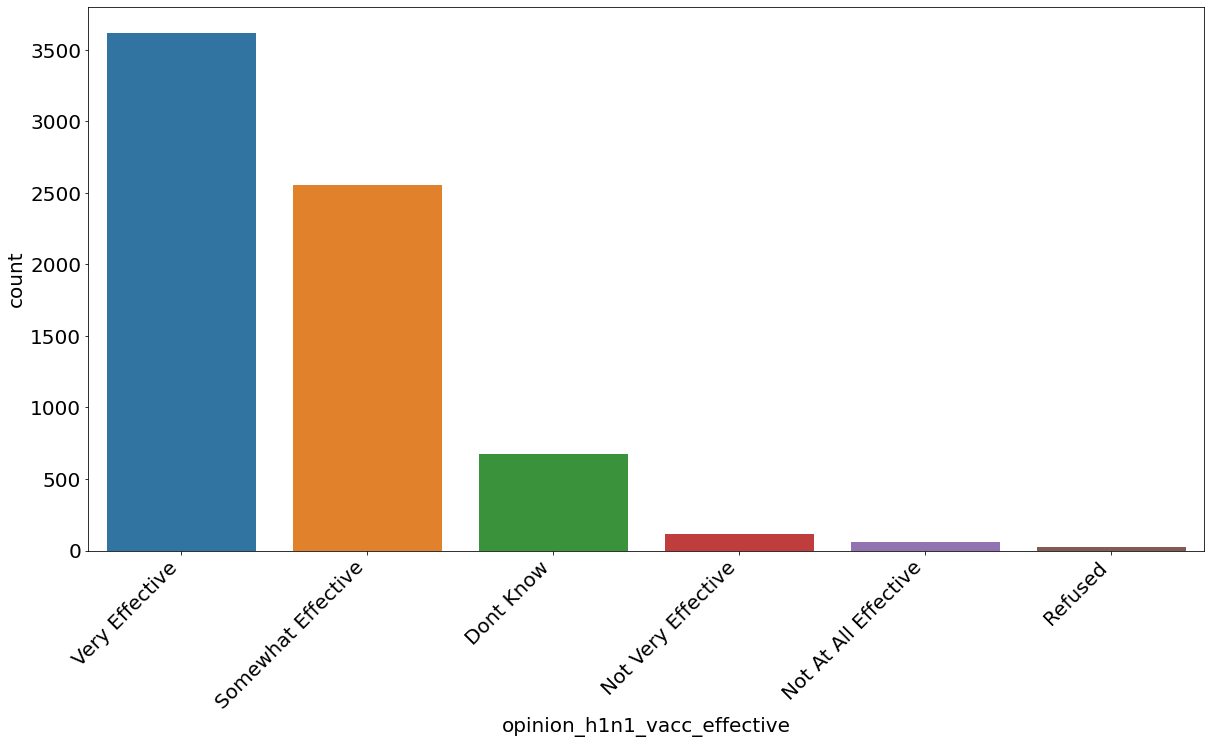

In [5]:
#일단 count 자체는 not very effective가 높다, 하지만 비율은 아니니 다시 계산해보자

fit, ax = plt.subplots(figsize = (20,10))
plt.xticks(rotation = 45, ha = 'right')
plt.rcParams['font.size'] = 20

order = ['Very Effective', 'Somewhat Effective', 'Dont Know', 'Not Very Effective', 'Not At All Effective', 'Refused']

sns.countplot(ax = ax, data = train_raw, x=train_raw['opinion_h1n1_vacc_effective'][train_raw[target] == 1], order = order)

In [6]:
# 직접 계산해보니 not at all effective를 찍은 사람의 접종률이 not very effective보다 살짝 더 높은 것이 맞다.

naae = train_raw[train_raw['opinion_h1n1_vacc_effective'] == 'Not At All Effective']
print(naae[target].sum() / len(naae))

nve = train_raw[train_raw['opinion_h1n1_vacc_effective'] == 'Not Very Effective']
print(nve[target].sum() / len(nve))

0.054005400540054004
0.05060553633217993


In [7]:
opinion_cols = [cols for cols in train_raw.columns if 'opinion' in cols]
opinion_cols

['opinion_h1n1_vacc_effective',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc']

In [8]:
# profile report 에서 개인의 의견(opinion) 관련 항목들끼리 상관관계가 높은 수치로 존재함을 확인 하였으며,
# 어제의 특성 중요도에서도 꽤 높은 중요도를 기록했다. 
# 따라서 opinion 관련 항목들을 engineering 해본다. 
# 각 항목 별 백신 접종률을 확인 후, 그에 맞게 수치형 데이터로 바꾼다. 

# opinion_h1n1_vacc_effective 항목은 위에서 이미 확인함.

<AxesSubplot:xlabel='opinion_h1n1_risk', ylabel='vacc_h1n1_f'>

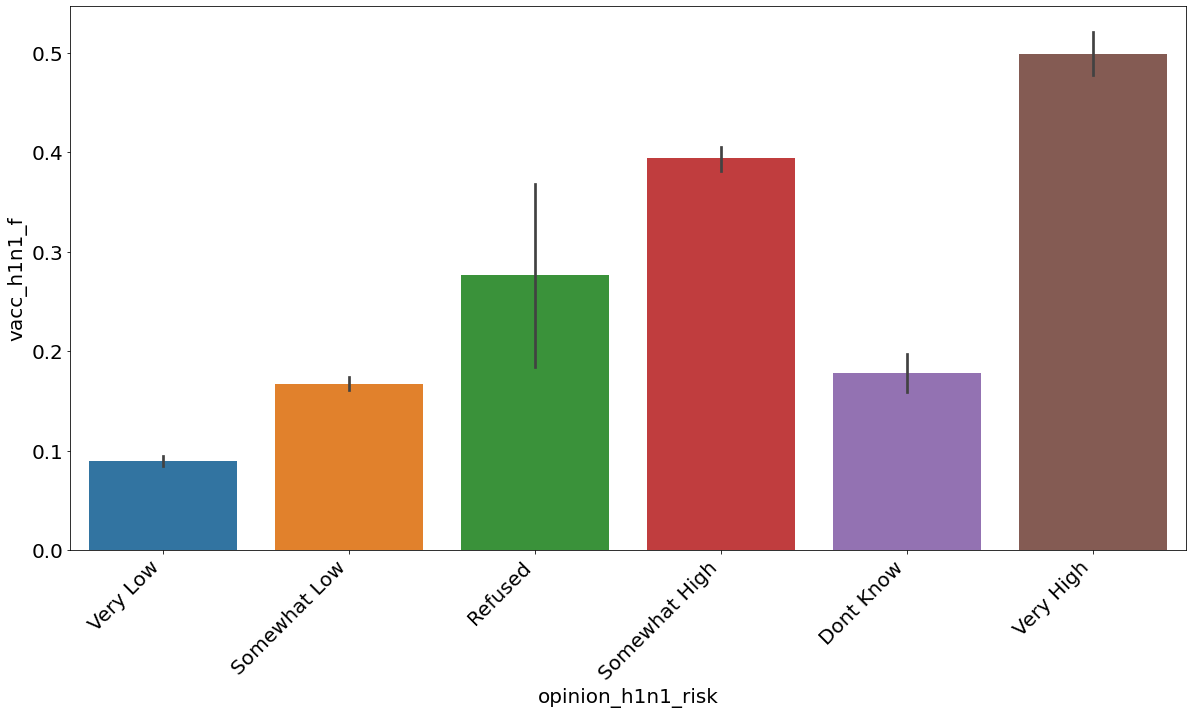

In [9]:
fit, ax = plt.subplots(figsize = (20,10))
plt.xticks(rotation = 45, ha = 'right')
plt.rcParams['font.size'] = 20

# order = ['Very Effective', 'Somewhat Effective', 'Dont Know', 'Not Very Effective', 'Not At All Effective', 'Refused']

sns.barplot(ax = ax, data = train_raw, x='opinion_h1n1_risk', y=target,)
           

<AxesSubplot:xlabel='opinion_h1n1_sick_from_vacc', ylabel='vacc_h1n1_f'>

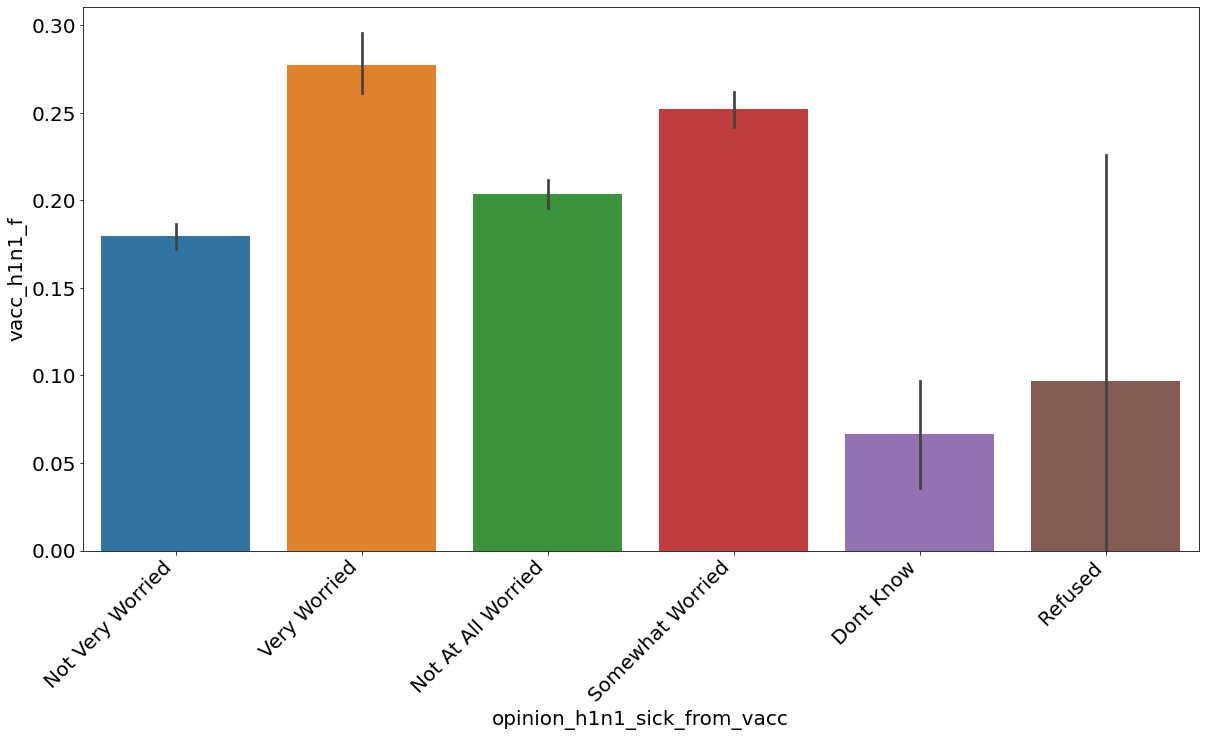

In [10]:
# 예상과 다르게 백신에 대한 두려움은 백신 접종률에 영향을 미치지 않는 것 같다. 
# 백신에 대한 두려움이 적을 수록 접종률이 높을 것이라 생각했지만, 꼭 그렇지 않은 것 같다. 
# 때문에 이 항목을 지워버리려 했지만, 기존의 예상대로 수치를 넣는 것이 점수가 더 높게 나온다... 
# 왜 그런지 모르겠지만 일단 점수를 위해 넣어두자... 미안해 내 양심

fit, ax = plt.subplots(figsize = (20,10))
plt.xticks(rotation = 45, ha = 'right')
plt.rcParams['font.size'] = 20

# order = ['Very Effective', 'Somewhat Effective', 'Dont Know', 'Not Very Effective', 'Not At All Effective', 'Refused']

sns.barplot(ax = ax, data = train_raw, x='opinion_h1n1_sick_from_vacc', y=target,)
           

In [11]:
# 혹시 몰라 다시 계산해봤지만, 위의 그래프가 맞다.

vw = train_raw[train_raw['opinion_h1n1_sick_from_vacc'] == 'Very Worried']
print(vw[target].sum() / len(vw))

0.2770689026613197


In [12]:
# train / val 데이터 나누기

from sklearn.model_selection import train_test_split

train, val = train_test_split(train_raw, train_size = 0.8, test_size = 0.2,
                             stratify = train_raw[target], random_state = 2)

In [13]:
# ordinal encoder가 어떤 것인지 먼저 써보았다.
# 근데 very effective가 제일 높은 번호를 받아야 할 것 같은데 순서가 뒤죽박죽이다.
# 이걸 쓰면 점수가 더 떨어질 것 같다.

df2 = train_raw.copy()

from category_encoders import OrdinalEncoder
ordinal = OrdinalEncoder(handle_missing="value")

ordinal.fit_transform(df2[opinion_cols],df2[target])

,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc
0,1,1,1,1,1,1
1,2,2,2,2,2,2
2,3,3,3,3,2,3
3,2,2,2,2,3,2
4,2,2,4,4,4,2
...,...,...,...,...,...,...
42149,3,5,2,2,2,2
42150,2,5,4,2,3,5
42151,3,3,4,3,5,2
42152,3,5,4,2,5,2


In [14]:
# 엔지니어링

# behavior관련 항목끼리 상관관계가 높으므로 서로 묶어서 한 특성으로 만든다.
# opinion 관련 항목끼리도 묶는다. 
# 묶은 후, 사용된 특성은 제거한다. 
# 이번에는 신종플루 관련 예측만 하므로 seas 관련 항목은 제거한다. 

import numpy as np

def engineer(df):
    
    # 새로운 특성을 생성합니다.
    behaviorals = [col for col in df.columns if 'behavioral' in col] 
    df['behavior'] = df[behaviorals].sum(axis=1)
    df.drop(columns = behaviorals, inplace=True)
    
    
    df['opinion_h1n1_vacc_effective'].replace({'Not At All Effective' : 0,
                                             'Not Very Effective' : 1,
                                             'Dont Know' : 2,
                                             'Refused' : 3,
                                             'Somewhat Effective' : 4,
                                             'Very Effective' : 5},
                                            inplace=True)
    df['opinion_h1n1_risk'].replace({'Very Low' : 0,
                                   'Somewhat Low' : 1,
                                   'Dont Know' : 2,
                                   'Refused' : 3,
                                   'Somewhat High' : 4,
                                   'Very High' : 5},
                                  inplace = True)
    df['opinion_h1n1_sick_from_vacc'].replace({'Dont Know' : 0,
                                              'Refused' : 1,
                                              'Very Worried' : 2,
                                              'Somewhat Worried' : 3,
                                              'Not Very Worried' : 4,
                                              'Not At All Worried' : 5},
                                             inplace = True)
    
    df['opi'] = df[['opinion_h1n1_risk','opinion_h1n1_vacc_effective', 'opinion_h1n1_sick_from_vacc']].sum(axis=1)

    opinions = [col for col in df.columns if 'opinion' in col] 
    df.drop(columns = opinions, inplace=True)
    
    
    dels = [col for col in df.columns if 'seas' in col]
    df.drop(columns=dels, inplace=True)
        
    return df


train = engineer(train)
val = engineer(val)

<ipython-input-14-6c3ddb170075>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['behavior'] = df[behaviorals].sum(axis=1)
C:\Users\tkryu\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\tkryu\anaconda3\lib\site-packages\pandas\core\series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r

In [15]:
# X,y 값 설정

features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

### 2) 랜덤포레스트 모델을 적용한 후의 결과를 캐글에 제출하세요.
- 랜덤포레스트를 적용하고 성능이 오히려 떨어졌을 수도 있습니다! 만약 그렇다면 이유를 본인 논리로 분석해 보세요.
- **캐글 Leaderboard의 본인 Score를 과제 제출폼에 제출하세요.**

In [16]:
### 이곳에서 과제를 진행해 주세요 ###

## 그냥 랜덤 포레스트를 돌려본다 ##
# 과적합이 너무 심하다.

# future warning 무시
import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)


from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from category_encoders import TargetEncoder
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

onehot_target = train.drop(columns=['state', target]).columns


pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True, cols = onehot_target),  
    TargetEncoder(cols = ['state']),
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, random_state=10, oob_score=True)
)

pipe.fit(X_train,y_train)
print('훈련 정확도: ', pipe.score(X_train, y_train))
print('검증 정확도: ', pipe.score(X_val, y_val))


from sklearn.metrics import f1_score

y_pred_val = pipe.predict(X_val)
f1_score(y_val, y_pred_val)

훈련 정확도:  0.9971829315304095
검증 정확도:  0.8230340410390227


0.5476046088538509

In [17]:
## 데이터 엔지니어링 전에 'opinion' 관련 항목들에 ordinal 인코더를 써봤는데 점수가 똥망이었다. 
## 데이터 엔지니어링을 다시 했으므로 여기는 주석 처리한다. 



# opinion_col = [cols for cols in train.columns if 'opinion' in cols]
# opinion_col

# from category_encoders import OrdinalEncoder

# onehot_target2 = train.drop(columns=['state', target, opinion_col[0], opinion_col[1], opinion_col[2]]).columns
# opinion_col = [cols for cols in train.columns if 'opinion' in cols]

# pipe2 = make_pipeline(
#     OneHotEncoder(use_cat_names=True, cols = onehot_target2),  
#     TargetEncoder(cols = ['state']),
#     OrdinalEncoder(handle_missing="value", cols = opinion_col ),
#     SimpleImputer(), 
#     RandomForestClassifier(n_jobs=-1, random_state=10, oob_score=True)
# )

# pipe2.fit(X_train,y_train)
# print('훈련 정확도: ', pipe2.score(X_train, y_train))
# print('검증 정확도: ', pipe2.score(X_val, y_val))


# from sklearn.metrics import f1_score

# y_pred_val = pipe2.predict(X_val)
# f1_score(y_val, y_pred_val)

In [18]:
# onehot 인코더만 썼을 때, f값은 그럭저럭 나쁘지 않다.

# 랜덤포레스트의 파라미터들을 만져보자. 
# 일단 class_weight = balanced를 넣으면 정확도는 떨어지지만 f값이 높아진다. 
# f 값이 목적이므로 해당 파라미터를 쓴다. 
# class_weight = balanced는 가중치를 평균으로 만들어서 f1값을 올리는데 도움을 준다. 

# 나무 심는 횟수, 트리의 깊이, 나뭇잎 개수는 수작업을 통해 최적값을 찾았다. 
# for문을 돌리면 주피터 노트북이 멈춰버려서 돌리지 못했다.

X_t = X_train.copy()
X_v = X_val.copy()

X_t.drop('state', axis = 1, inplace = True)
X_v.drop('state', axis = 1, inplace = True)



from category_encoders import OrdinalEncoder

# onehot_target2 = train.drop(columns=['state', target, opinion_col[0], opinion_col[1], opinion_col[2]]).columns
# opinion_col = [cols for cols in train.columns if 'opinion' in cols]

pipe3 = make_pipeline(
    OneHotEncoder(use_cat_names=True),  
#     TargetEncoder(cols = ['state']),
#     OrdinalEncoder(handle_missing="value", cols = opinion_col ),
    SimpleImputer(), 
    RandomForestClassifier(n_estimators = 512, n_jobs=-1, random_state=2, oob_score=True, class_weight='balanced',
                           criterion = "entropy", max_depth = 12, min_samples_leaf = 6)
)

pipe3.fit(X_train,y_train)
print('훈련 정확도: ', pipe3.score(X_train, y_train))
print('검증 정확도: ', pipe3.score(X_val, y_val))


from sklearn.metrics import f1_score

y_pred_val = pipe3.predict(X_val)
f1_score(y_val, y_pred_val)

훈련 정확도:  0.7869999703466477
검증 정확도:  0.7765389633495433


0.6144085141219812

In [19]:
# state 항목에 대해서만 target 인코더를 썼을 때, 
# 점수가 약간 더 높다. 

from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from category_encoders import TargetEncoder
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

onehot_target = train.drop(columns=['state', target]).columns


pipe4 = make_pipeline(
    OneHotEncoder(use_cat_names=True, cols = onehot_target),  
    TargetEncoder(cols = ['state']),
    SimpleImputer(), 
    RandomForestClassifier(n_estimators = 512, n_jobs=-1, random_state=2, oob_score=True, class_weight='balanced',
                           criterion = "entropy", max_depth = 12, min_samples_leaf = 6)
)

pipe4.fit(X_train,y_train)
print('훈련 정확도: ', pipe4.score(X_train, y_train))
print('검증 정확도: ', pipe4.score(X_val, y_val))


from sklearn.metrics import f1_score

y_pred_val = pipe4.predict(X_val)
f1_score(y_val, y_pred_val)

훈련 정확도:  0.7975269104172227
검증 정확도:  0.7853160953623533


0.6181434599156117

## 🔥 도전과제

### 3) 수업에 사용하지 않은 다른 종류의 [category_encoders](http://contrib.scikit-learn.org/category_encoders/)을 적용해 보고 인코더에 대해 설명하세요


In [20]:
# 이곳에서 과제를 진행해 주세요 ###

# 어제부터 썼던 거지만, Target encoder에 대한 내용을 다시 씀. 
# Target encoder : 카디널리티가 높은 특성에 사용하면 좋다. 범주 값을 대상의 다른 특성의 평균값으로 대체한다. 

# 꼭 카디널리티가 높은 특성이 아니더라도 categorical한 데이터에 많이 쓴다고 해서 
# 아예 onehot 인코더를 쓰지 않고 target 인코더만 써봄
# 점수가 더 높음


from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from category_encoders import TargetEncoder
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

onehot_target = train.drop(columns=['state', target]).columns


pipe5 = make_pipeline(

    TargetEncoder(),
    SimpleImputer(), 
    RandomForestClassifier(n_estimators = 512, n_jobs=-1, random_state=2, oob_score=True, class_weight='balanced',
                           criterion = "entropy", max_depth = 12, min_samples_leaf = 6)
)

pipe5.fit(X_train,y_train)
print('훈련 정확도: ', pipe5.score(X_train, y_train))
print('검증 정확도: ', pipe5.score(X_val, y_val))


from sklearn.metrics import f1_score

y_pred_val = pipe5.predict(X_val)
f1_score(y_val, y_pred_val)

훈련 정확도:  0.8272395694333244
검증 정확도:  0.798481793381568


0.6276572430418584

In [21]:
# 이곳에서 과제를 진행해 주세요 ###

# Catboost encoder : target 인코딩과 비슷하다. 대상 값에 대한 확률을 기반으로 범주 값을 예측하여 대체한다. 

# Catboost 인코더라는 것을 써봄. 설명에는 target 인코더의 단점을 보완한 것이라고 하는데 점수는 더 낮음. 


from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from category_encoders import TargetEncoder
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from category_encoders import CatBoostEncoder


pipe6 = make_pipeline(
    CatBoostEncoder(),
    SimpleImputer(), 
    RandomForestClassifier(n_estimators = 512, n_jobs=-1, random_state=2, oob_score=True, class_weight='balanced',
                           criterion = "entropy", max_depth = 12, min_samples_leaf = 6)
)

pipe6.fit(X_train,y_train)
print('훈련 정확도: ', pipe6.score(X_train, y_train))
print('검증 정확도: ', pipe6.score(X_val, y_val))


from sklearn.metrics import f1_score

y_pred_val = pipe6.predict(X_val)
f1_score(y_val, y_pred_val)

훈련 정확도:  0.8091213711710109
검증 정확도:  0.797888743921243


0.6263157894736843

In [22]:
# 카디널리티가 높은 특성들은 target 인코더를 쓰고, 
# 나머지는 cat boost를 써보니 점수가 가장 높았다. 

target_col = ['employment_industry', 'state', 'employment_occupation']
cat_col = X_train.drop(columns = target_col).columns



pipe7 = make_pipeline(
    TargetEncoder(cols = target_col),
    CatBoostEncoder(cols = cat_col),
    SimpleImputer(), 
    RandomForestClassifier(n_estimators = 512, n_jobs=-1, random_state=2, oob_score=True, class_weight='balanced',
                           criterion = "entropy", max_depth = 12, min_samples_leaf = 6)
)

pipe7.fit(X_train,y_train)
print('훈련 정확도: ', pipe7.score(X_train, y_train))
print('검증 정확도: ', pipe7.score(X_val, y_val))


from sklearn.metrics import f1_score

y_pred_val = pipe7.predict(X_val)
f1_score(y_val, y_pred_val)

훈련 정확도:  0.811730866174421
검증 정확도:  0.8109358320483928


0.6352402745995424

In [23]:
# 일단 마지막 모델로 제출

test_raw = pd.read_csv(url_test)
submission = pd.read_csv(url_submission)

# test 데이터 전처리, 이전에 썼던 train & val 합쳐서 다시 전처리
test = engineer(test_raw)
trainer = engineer(train_raw)

In [24]:
# 모델 학습

X_trainer = trainer[features]
y_trainer = trainer[target]

pipe7.fit(X_trainer, y_trainer)

y_pred_test = pipe7.predict(test)

In [25]:
# submission 폼에 덮어씌우기

submission['vacc_h1n1_f'] = y_pred_test

In [26]:
# 제출용 파일 만들기

submission.to_csv("submission5.csv", index=False)

In [35]:
pipeline.steps


NameError: name 'pipeline' is not defined

In [33]:
import graphviz
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier

model_dt = pipe7.named_steps['RandomForestClassifier']
enc = pipe7.named_steps['onehotencoder']
encoded_columns = enc.transform(X_val).columns

dot_data = export_graphviz(model_dt
                          , max_depth=3
                          , feature_names=encoded_columns
                          , class_names=['no', 'yes']
                          , filled=True
                          , proportion=True)


display(graphviz.Source(dot_data))

KeyError: 'RandomForestClassifier'

In [34]:
import matplotlib.pyplot as plt

model_dt = pipe7.named_steps['RandomForestClassifier']

importances = pd.Series(model_dt.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh();

KeyError: 'RandomForestClassifier'

## 참고자료

- [Random Forests for Complete Beginners](https://victorzhou.com/blog/intro-to-random-forests/)

# 타입폼 문제

### 1. (객관식) 다음 특성들 중에 순서를 고려한 Ordinal Encoding이 필요해 보이는 특성을 선택하고 과제 제출폼에 제출하세요.
1. opinion_h1n1_vacc_effective
2. state
3. marital
4. employment_occupation

 -> 1번

### 2. 캐글 Leaderboard의 본인 Score를 과제 제출폼에 제출하세요.

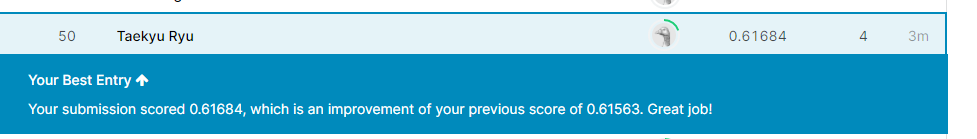